# 导入库

In [149]:
import keras 
import numpy as np
import urllib
import tarfile
import os
import matplotlib.pyplot as plt

%matplotlib inline
from keras.preprocessing import image
from scipy.misc import imresize
from imageio import imread, imsave, mimsave
import glob

# 下载数据并解压

In [150]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz' 
file_name = '/Users/liuhuan/Downloads/lfw.tar'
directory = '/Users/liuhuan/Downloads/lfw/'
new_dir = '/Users/liuhuan/Downloads/lfw_new_imgs'

if not os.path.isdir(new_dir):
    os.mkdir(new_dir) #创建重组图片文件夹

    if not os.path.isdir(directory):
        if not os.path.isfile(file_name):
            urllib.request.urlretrieve(url=url, filename=file_name)
        tar = tarfile.open(file_name, 'r:gz')
        tar.extractall(path=directory)
        tar.close()

    count = 0

    for dir_,_, files in os.walk(directory):
        for file_ in files:
            img = imread(os.path.join(dir_, file_))
            imsave(os.path.join(new_dir, '%d.png' %count), img)
            count += 1

# 设定用于生成人脸的数据集

In [151]:
from keras.preprocessing.image import load_img, img_to_array
datasets = new_dir
images = glob.glob(os.path.join(datasets, '*.*'))
img_len = len(images)

# 设置空的data用于存放数据
datasets = np.empty(shape=(img_len, img_width, img_height, channels), dtype='float32')

# 逐个读取图片
for i in range(img_len):
    img = load_img(images[i])
    img = img_to_array(img)
    datasets[i, :, :, :] = img

datasets.shape

(3148, 250, 250, 3)

# 对图片进行归一化

In [189]:
datasets = datasets / 255.
datasets = datasets[:, :240, :240, :]

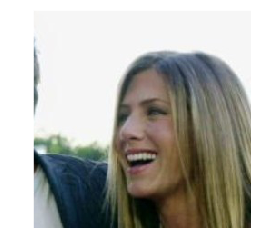

In [200]:
datasets.shape
img = image.array_to_img(datasets[0])
plt.imshow(img)
plt.show()

# 定义常量、网络输入、辅助函数

In [191]:
batch_size = 20
latent_dim = 240
WIDTH = 240
HEIGHT = 240
channels = 3

OUTPUT_DIR = "/Users/liuhuan/Downloads/" + 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)


# 生成器

In [192]:
from keras.models import Model
from keras import layers
import keras

generator_Input = keras.Input(shape=(latent_dim,))
d = 15
x = layers.Dense(d*d*512)(generator_Input)
x = layers.ReLU()(x)
x = layers.Reshape(target_shape=(d, d, 512))(x)

x = layers.Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2,padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(kernel_size=5, filters=3, strides=2, padding='same', activation='relu')(x)

generator = keras.models.Model(generator_Input, x)

generator.summary() 

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 240)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 115200)            27763200  
_________________________________________________________________
re_lu_106 (ReLU)             (None, 115200)            0         
_________________________________________________________________
reshape_34 (Reshape)         (None, 15, 15, 512)       0         
_________________________________________________________________
conv2d_transpose_102 (Conv2D (None, 30, 30, 256)       3277056   
_________________________________________________________________
re_lu_107 (ReLU)             (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_transpose_103 (Conv2D (None, 60, 60, 128)       819

# 判别器

In [193]:
descriminator_input = layers.Input(shape=(WIDTH, HEIGHT, channels))
x = layers.Conv2D(kernel_size=5, filters=64, strides=2, padding='same')(descriminator_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(kernel_size=5, filters=128, strides=2, padding='same')(x)
x = layers.normalization.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(kernel_size=5, filters=256, strides=2, padding='same')(x)
x = layers.normalization.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(kernel_size=5, filters=512, strides=2, padding='same')(x)
x = layers.normalization.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

descriminator = keras.models.Model(descriminator_input,x)
descriminator.summary()

# 优化器
descriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8
)

descriminator.compile(optimizer=descriminator_optimizer, 
                      loss='binary_crossentropy'    
)


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 120, 120, 64)      4864      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 60, 60, 128)       204928    
_________________________________________________________________
batch_normalization_29 (Batc (None, 60, 60, 128)       512       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 30, 30, 256)       819

# 对抗网络

In [194]:
# 将判别器权重设置为不可训练
descriminator.trainable = False

# 输入
gan_input = keras.Input(shape=(latent_dim,))

gan_output = descriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, 
                                         clipvalue=1.0,
                                         decay=1e-8)
gan.compile(optimizer=gan_optimizer, 
            loss='binary_crossentropy')
gan.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 240)               0         
_________________________________________________________________
model_38 (Model)             (None, 240, 240, 3)       32069251  
_________________________________________________________________
model_39 (Model)             (None, 1)                 4425345   
Total params: 36,494,596
Trainable params: 32,069,251
Non-trainable params: 4,425,345
_________________________________________________________________


# 训练

In [201]:
generated_path = '/Users/liuhuan/Downloads/lfw_generated'

# 创建生成图片文件夹
if not os.path.exists(generated_path):
    os.mkdir(generated_path)

iterations = 10000
batch_size = 20

start = 0
for step in range(iterations):
    # 噪声生成图片
    z = np.random.normal(size=(batch_size, latent_dim))
    generated_image = generator.predict(z)

    #真实图片
    stop = start + batch_size
    real_images = datasets[start: stop]
    
    # 图片混合
    combined_images = np.concatenate([generated_image, real_images])

    # 标签生成
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size,1))])
    labels += 0.05 * np.random.random(labels.shape)

    # 判别器训练
    d_loss = descriminator.train_on_batch(combined_images, labels)
    
    # 
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    
    if start> len(datasets) - batch_size:
        start = 0
        
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)

        img = image.array_to_img(generated_image[0] * 255., scale=False)
        img.save(os.path.join("/Users/liuhuan/Downloads/lfw_generated/", 'generated_face'+str(step) + '.png'))


# 读取图片函数

In [0]:
def read_image(path, height, width):
    image = imread(path)
    h = image.shape[0]
    w = image.shape[1]

    if h>w:
        image = image[h//2 - w//2: h//2 + w//2, :,:]
    else:
        image = image[:, w//2-h//2:w//2+h//2,:]
    
    image = imresize(image,(HEIGHT, WIDTH))
    return image/255.

(250, 250, 3)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # This is added back by InteractiveShellApp.init_path()


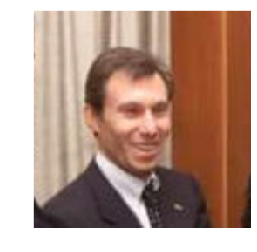